Epoch 1/5, Loss: 360.9417
Epoch 2/5, Loss: 230.9527
Epoch 3/5, Loss: 194.4571
Epoch 4/5, Loss: 169.1118
Epoch 5/5, Loss: 147.7551


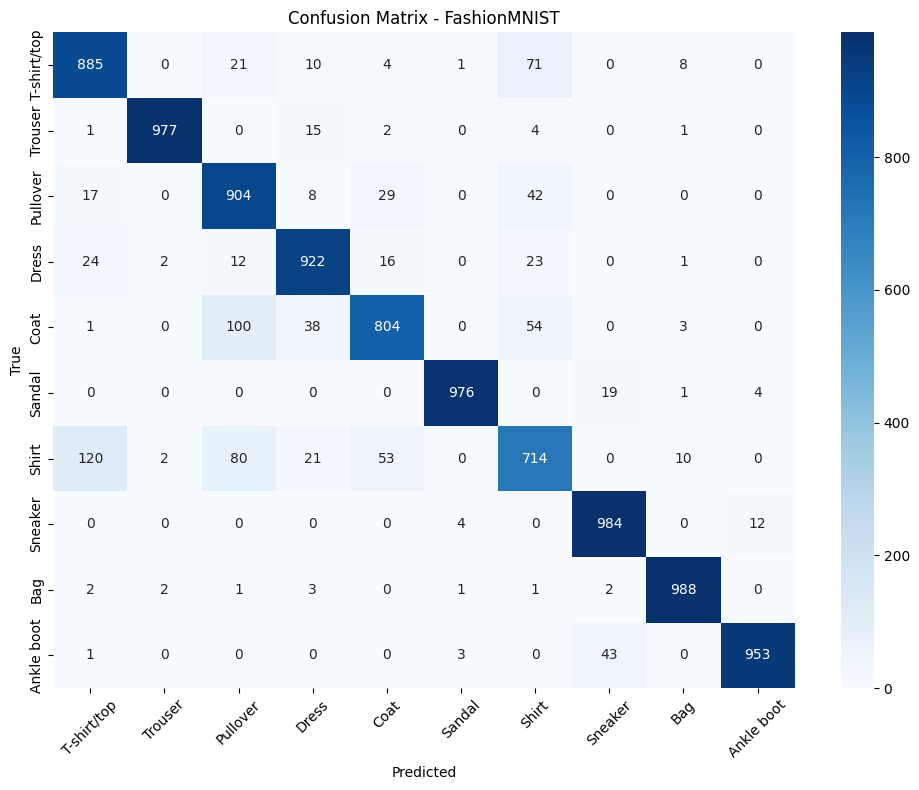

📋 Classification Report:
              precision    recall  f1-score   support

 T-shirt/top     0.8421    0.8850    0.8630      1000
     Trouser     0.9939    0.9770    0.9854      1000
    Pullover     0.8086    0.9040    0.8536      1000
       Dress     0.9066    0.9220    0.9142      1000
        Coat     0.8855    0.8040    0.8428      1000
      Sandal     0.9909    0.9760    0.9834      1000
       Shirt     0.7855    0.7140    0.7480      1000
     Sneaker     0.9389    0.9840    0.9609      1000
         Bag     0.9763    0.9880    0.9821      1000
  Ankle boot     0.9835    0.9530    0.9680      1000

    accuracy                         0.9107     10000
   macro avg     0.9112    0.9107    0.9101     10000
weighted avg     0.9112    0.9107    0.9101     10000



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset_full = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_dataset, val_dataset = random_split(dataset_full, [50000, 10000])

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.net(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 5
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss:.4f}")

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - FashionMNIST")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))


In [ ]:
torch.save(model.state_dict(), "fashionista.pth")
